In [1]:
version = 'v20250521'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

point = pd.read_parquet(f'./material/soc.topsoil_organized_{version}.pq')
series = pd.read_parquet(f'./material/srs_lucas.plausible_{version}.pq')
pair = pd.read_parquet(f'./material/pair_lucas.plausible_{version}.pq')

## temporal distribution

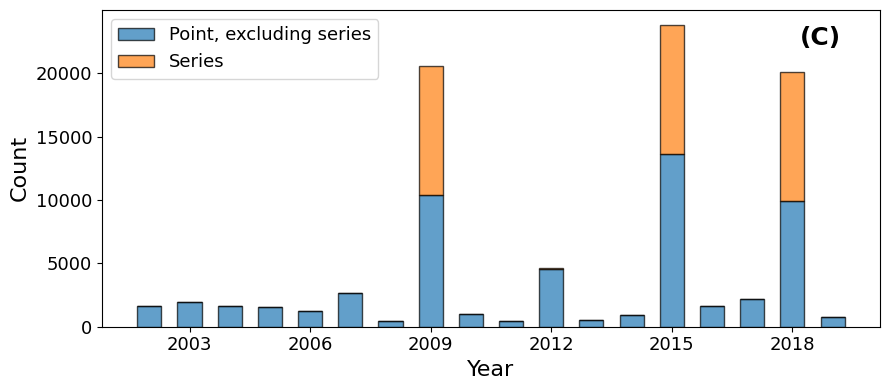

In [4]:
pnt_series = point.loc[point['id'].isin(series['id'].values)]

# Create time bins
time_bins = np.arange(min(point['time'].min(), pnt_series['time'].min()), 
                      max(point['time'].max(), pnt_series['time'].max()) + 1)

# Histogram counts per year
series_counts, _ = np.histogram(pnt_series['time'], bins=time_bins)
point_counts, _ = np.histogram(point['time'], bins=time_bins)
non_series_counts = point_counts - series_counts

# X-axis (mid of bins)
bin_centers = time_bins[:-1]
bar_width = 0.6

# Create single plot
fig, ax = plt.subplots(figsize=(9, 4))

# Plot stacked bars
ax.bar(bin_centers, non_series_counts, width=bar_width, label='Point, excluding series', alpha=0.7, edgecolor='black')
ax.bar(bin_centers, series_counts, width=bar_width, bottom=non_series_counts, label='Series', alpha=0.7, edgecolor='black')

# X-axis formatting
x_ticks = [2003, 2006, 2009, 2012, 2015, 2018]
ax.set_xticks(x_ticks)
ax.tick_params(labelsize=13)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.legend(fontsize=13)
# ax.grid(True)
ax.text(0.95, 0.95, '(C)', transform=ax.transAxes,
        ha='right', va='top', fontsize=18, fontweight='semibold')#, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')


plt.tight_layout()
plt.savefig(f'./figure/fig_data_temp.availibility.svg')
plt.show()

## pair distribution

In [37]:
pair['time'] = pair['time_pair'].apply(lambda x: f"{x[0]}-{x[1]}")
pair['time_diff'] = pair['time_pair'].apply(lambda x: x[1]-x[0])
pair['time_start'] = pair['time_pair'].apply(lambda x: x[0])
pair['time_end'] = pair['time_pair'].apply(lambda x: x[1])

ac = pair.value_counts(subset=['time', 'time_start','time_end','time_diff']).reset_index(name='count')
ac = ac.loc[[1,2,3,4,0]]

In [38]:
ac

,time,time_start,time_end,time_diff,count
1,2009-2015,2009,2015,6,10151
2,2009-2018,2009,2018,9,10151
3,2012-2015,2012,2015,3,53
4,2012-2018,2012,2018,6,53
0,2015-2018,2015,2018,3,10204


/tmp/ipykernel_7574/1954445676.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ac['time'], rotation=10)


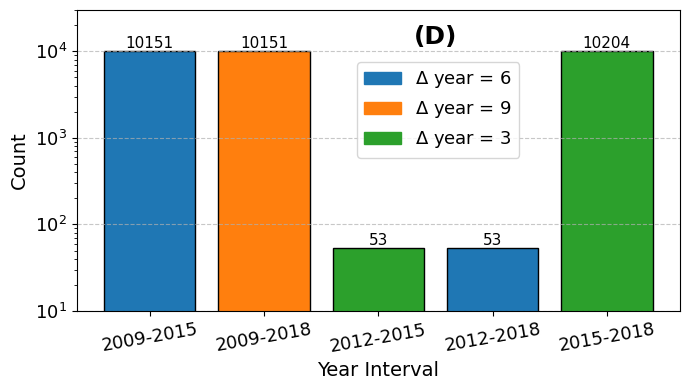

In [72]:


# Color map based on unique time_diff values
unique_diffs = ac['time_diff'].unique()
color_map = {diff: color for diff, color in zip(unique_diffs, plt.cm.tab10.colors)}
bar_colors = ac['time_diff'].map(color_map)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(ac['time'], ac['count'], color=bar_colors, edgecolor='black')

# Custom legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[diff]) for diff in unique_diffs]
labels = [f"$\Delta$ year = {diff}" for diff in unique_diffs]
ax.legend(handles, labels, fontsize=13, bbox_to_anchor=(0.45, 0.48))

# Labels and styling
ax.set_xlabel('Year Interval', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(ac['time'], rotation=10)
ax.tick_params(labelsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_ylim([10, 30000])  # Avoid setting to 0 on log scale

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=11
    )

# Add panel label
ax.text(0.63, 0.95, '(D)', transform=ax.transAxes,
        ha='right', va='top', fontsize=18, fontweight='semibold')

# Save and show
plt.tight_layout()
plt.savefig(f'./figure/fig_data.pair_temp.availibility.svg', format='svg', bbox_inches='tight')
plt.show()


## descriptive stats

In [5]:
stat = point.groupby(['ref'])['soc'].describe()[['count','mean','50%','std']]

In [6]:
stat['n_site'] = np.nan
for ii in point['ref'].unique():
    ln = len(point.loc[point['ref']==ii, 'id'].unique())
    stat.loc[stat.index==ii,'n_site'] = ln

In [7]:
stat.sort_values(by='count',ascending=False)[['n_site','count','mean','50%','std']]

,n_site,count,mean,50%,std
ref,,,,,
LUCAS,27737.0,62437.0,45.978352,20.700000,82.029290
ParcelasINES,21502.0,21505.0,36.629255,23.530000,38.665153
thuenen.bze.lw,2953.0,2953.0,30.069683,18.372983,49.221224
ParcelasCOS,789.0,789.0,40.784685,27.170000,34.643113
